In [1]:
from __future__ import print_function
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Lambda
from keras import backend as K
import numpy as np

Using TensorFlow backend.


In [2]:
def neg_hscore(x):
    """
    negative hscore calculation
    """
    f = x[0]
    g = x[1]
    f0 = f - K.mean(f, axis = 0)
    g0 = g - K.mean(g, axis = 0)
    corr = tf.reduce_mean(tf.reduce_sum(tf.multiply(f0, g0), 1))
    cov_f = K.dot(K.transpose(f0), f0) / K.cast(K.shape(f0)[0] - 1, dtype = 'float32')
    cov_g = K.dot(K.transpose(g0), g0) / K.cast(K.shape(g0)[0] - 1, dtype = 'float32')
    return - corr + tf.trace(K.dot(cov_f, cov_g)) / 2

In [3]:
# build H-score model
def build_model():
    input_shape = (28,28,1)
    fdim = 10
    gdim = 10
    input_x = Input(shape = input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)(input_x)
    conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    f = Dropout(0.25)(pool)
    f = Flatten()(f)
    f = Dense(128, activation='relu')(f)
    f = Dropout(0.5)(f)
    f = Dense(fdim, activation='relu')(f)
    input_y = Input(shape = (num_classes, ))

    g = Dense(gdim, activation='relu')(input_y)

    loss = Lambda(neg_hscore)([f, g])
    model = Model(inputs = [input_x, input_y], outputs = loss)
    model.compile(optimizer=keras.optimizers.Adadelta(), loss = lambda y_true,y_pred: y_pred)
    return model

In [15]:
# build log-loss model
def build_model_logloss():
    input_shape = (28,28,1)
    fdim = 10
    gdim = 10
    input_x = Input(shape = input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)(input_x)
    conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    f = Dropout(0.25)(pool)
    f = Flatten()(f)
    f = Dense(128, activation='relu')(f)
    f = Dropout(0.5)(f)
    f = Dense(10, activation='relu')(f)
    pred = Dense(10, activation='softmax')(f)
    model = Model(inputs = input_x, outputs = pred)
    model.compile(optimizer=keras.optimizers.Adadelta(), loss = 'categorical_crossentropy',metrics=['accuracy'])
    return model

# H-score evaluation

In [4]:
# Keras callback, evaluate validation accuracy after each epoch, for H-score model
class evaluateAccu(keras.callbacks.Callback):
    def __init__(self,train_label,test_label,**kwargs):
        super(evaluateAccu, self).__init__(**kwargs)
        self.py = np.mean(train_label, axis = 0)
        self.train_label = train_label
        self.test_label = test_label
        
    def on_train_begin(self, logs={}):
        self.val_accus = []
        
    def on_epoch_end(self,epoch,logs={}):
        f = K.function([self.model.layers[0].input], [self.model.layers[9].get_output_at(-1)])
        g = K.function([self.model.layers[8].input], [self.model.layers[10].get_output_at(-1)])
        
        f_test = f([self.validation_data[0]])
        f_test = f_test[0]
        
        g_test = g([np.eye(10)])
        g_test = g_test[0]
        
        val_accu = self.evaluate_accu(f_test,g_test,self.test_label)
        self.val_accus.append(val_accu)
        
    def evaluate_accu(self,f,g,gt_label):
        f = f - np.mean(f, axis = 0)
        g = g - np.mean(g, axis = 0)
        pygx = self.py * (1 + np.matmul(f, g.T))
        accu = np.mean(np.argmax(pygx, axis = 1) == np.argmax(gt_label, axis = 1))
        return accu
        

# prepare MNIST data 

In [24]:
# prepare training and test data
batch_size = 128
num_classes = 10
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train,axis=-1)
x_test = np.expand_dims(x_test,axis=-1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# train two models

In [25]:
# train H-score model
mnist_model = build_model()
evaluate_accu = evaluateAccu(y_train,y_test)
history = mnist_model.fit([x_train, y_train], 
                    np.zeros([y_train.shape[0], 1]), 
                    batch_size = batch_size, epochs = epochs, 
                    callbacks = [evaluate_accu],
                    validation_data=([x_test, y_test],np.zeros([y_test.shape[0], 1])))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 80us/step - loss: -2.6938 - val_loss: -3.6602
Epoch 2/20
60000/60000 [==============================] - 4s 63us/step - loss: -3.4050 - val_loss: -3.8527
Epoch 3/20
60000/60000 [==============================] - 4s 60us/step - loss: -3.5287 - val_loss: -3.9517
Epoch 4/20
60000/60000 [==============================] - 4s 60us/step - loss: -3.6032 - val_loss: -3.9320
Epoch 5/20
60000/60000 [==============================] - 4s 60us/step - loss: -3.6556 - val_loss: -4.0106
Epoch 6/20
60000/60000 [==============================] - 3s 57us/step - loss: -3.7115 - val_loss: -3.9912
Epoch 7/20
60000/60000 [==============================] - 4s 61us/step - loss: -3.7322 - val_loss: -4.0173
Epoch 8/20
60000/60000 [==============================] - 4s 61us/step - loss: -3.7668 - val_loss: -3.9875
Epoch 9/20
60000/60000 [==============================] - 4s 65us/step - loss: -3.8057 - val_l

In [28]:
# train log-loss model
logloss_model = build_model_logloss()
logloss_history = logloss_model.fit(x_train, y_train,
                  batch_size = batch_size, epochs = epochs, 
                  validation_data=(x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.3908 - acc: 0.8769 - val_loss: 0.0667 - val_acc: 0.9795
Epoch 2/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1112 - acc: 0.9691 - val_loss: 0.0533 - val_acc: 0.9826
Epoch 3/20
60000/60000 [==============================] - 4s 67us/step - loss: 0.0824 - acc: 0.9766 - val_loss: 0.0402 - val_acc: 0.9870
Epoch 4/20
60000/60000 [==============================] - 4s 67us/step - loss: 0.0667 - acc: 0.9815 - val_loss: 0.0379 - val_acc: 0.9878
Epoch 5/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0551 - acc: 0.9841 - val_loss: 0.0327 - val_acc: 0.9896
Epoch 6/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.0502 - acc: 0.9853 - val_loss: 0.0319 - val_acc: 0.9899
Epoch 7/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.0456 - acc: 0.9863 - val_loss: 0.0342 - val_acc

# plot losses and accus

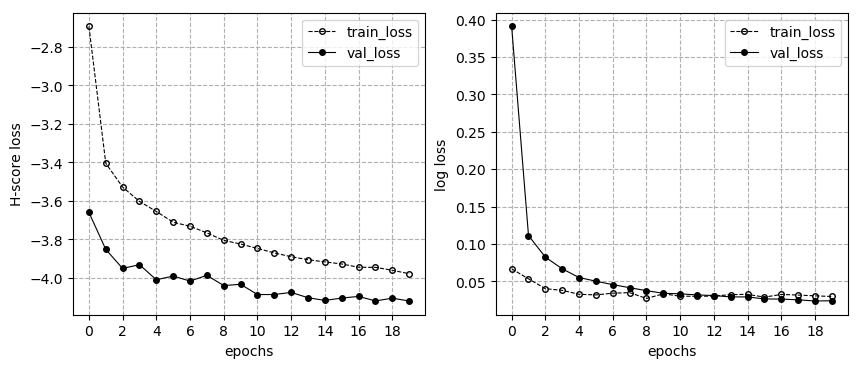

In [62]:
import matplotlib.pyplot as plt
plt.close()
plt.figure(figsize=(10,4),dpi=100)
plt.subplot(1,2,1)
plt.ylabel('H-score loss')
plt.xlabel('epochs')
plt.xticks([i*2 for i in range(int(epochs/2))], rotation=0)
plt.plot(range(epochs),history.history['loss'],'black',marker='o',linestyle='dashed',fillstyle='none',linewidth=0.8,ms=4,label="train_loss")
plt.plot(range(epochs),history.history['val_loss'], 'black', marker='o',linewidth=0.8,ms=4,label="val_loss")
plt.grid(axis='x', ls='--')
plt.grid(axis='y', ls='--')
plt.legend()
plt.subplot(1,2,2)
plt.ylabel('log loss')
plt.xlabel('epochs')
plt.xticks([i*2 for i in range(int(epochs/2))], rotation=0)
plt.plot(range(epochs),logloss_history.history['val_loss'],'black',marker='o',linestyle='dashed',fillstyle='none',linewidth=0.8,ms=4,label="train_loss")
plt.plot(range(epochs),logloss_history.history['loss'], 'black', marker='o',linewidth=0.8,ms=4,label="val_loss")
plt.grid(axis='x', ls='--')
plt.grid(axis='y', ls='--')
plt.legend()
plt.show()
# plt.savefig('mnist_loss.pdf',bbox_inches="tight")

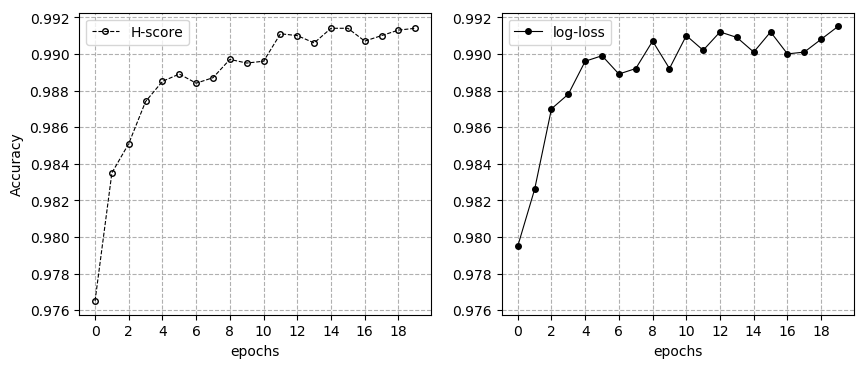

In [63]:
plt.close()
plt.figure(figsize=(10,4),dpi=100)
ax1=plt.subplot(1,2,1)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.xticks([i*2 for i in range(int(epochs/2))], rotation=0)
plt.plot(range(epochs),evaluate_accu.val_accus,'black',marker='o',linestyle='dashed',fillstyle='none',linewidth=0.8,ms=4,label="H-score")
plt.xticks([i*2 for i in range(int(epochs/2))], rotation=0)
# my_y_ticks = np.arange(0.9, 1, 10)
# plt.yticks(my_y_ticks)
plt.grid(axis='x', ls='--')
plt.grid(axis='y', ls='--')
plt.legend()
plt.subplot(1,2,2,sharey=ax1)
plt.xlabel('epochs')
plt.xticks([i*2 for i in range(int(epochs/2))], rotation=0)
plt.plot(range(epochs),logloss_history.history['val_acc'], 'black', marker='o',linewidth=0.8,ms=4,label="log-loss")
plt.grid(axis='x', ls='--')
plt.grid(axis='y', ls='--')
plt.legend()
plt.show()
# plt.savefig('mnist_accu.pdf',bbox_inches="tight")